**GRASP-AND-LIFT EEG Detection Project**

This project aims to compare different machine learning models in terms of viability for detecting events from EEG signals.

In [18]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

**Introduction**

Training data consists of EEG recordings of subjects performing grasp-and-lift trials.

There are 12 subjects in total, 10 series of trials for each subject.

Each series recorded 32 EEG channels with sampling rate 500Hz.

Training data contains id columns, representing the subject, series, and time at which data point was recorded.


In [19]:
train_set_signals = pd.read_csv("data/train/subj1_series1_data.csv")
train_set_signals.head()

,id,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,...,P7,P3,Pz,P4,P8,PO9,O1,Oz,O2,PO10
0,subj1_series1_0,-31,363,211,121,211,15,717,279,35,...,536,348,383,105,607,289,459,173,120,704
1,subj1_series1_1,-29,342,216,123,222,200,595,329,43,...,529,327,369,78,613,248,409,141,83,737
2,subj1_series1_2,-172,278,105,93,222,511,471,280,12,...,511,319,355,66,606,320,440,141,62,677
3,subj1_series1_3,-272,263,-52,99,208,511,428,261,27,...,521,336,356,71,568,339,437,139,58,592
4,subj1_series1_4,-265,213,-67,99,155,380,476,353,32,...,550,324,346,76,547,343,446,171,67,581


The aim is to predict whether a certain event is occuring at a given point.

There are 6 events. If an event occured at a given point is represented by 1, 0 otherwise.      


In [20]:
train_set_labels = pd.read_csv("data/train/subj1_series1_events.csv")
train_set_labels.head()

,id,HandStart,FirstDigitTouch,BothStartLoadPhase,LiftOff,Replace,BothReleased
0,subj1_series1_0,0,0,0,0,0,0
1,subj1_series1_1,0,0,0,0,0,0
2,subj1_series1_2,0,0,0,0,0,0
3,subj1_series1_3,0,0,0,0,0,0
4,subj1_series1_4,0,0,0,0,0,0


Setup for visualizations

In [21]:
labels = train_set_labels.columns.drop('id')
labelNames = labels.values

In [22]:
train_set_complete = pd.concat([train_set_signals,train_set_labels], axis=1)
train_set_complete.insert(0, "order", range(0, len(train_set_complete)))

In [23]:
def highlight(indices,ax,color):
    i=0
    while i<len(indices):
        ax.axvspan(indices[i]-0.5, indices[i]+0.5, facecolor=color, edgecolor='none', alpha=.4)
        i+=1      
    

In [24]:
def vizualize_predictions(signals, predictions, expected, labelName, limit=2000): 
    #0-31
    signalIndex = 10
    
    #Relevant only for multilabel predictions, else is always 0
    labelIndex = 0
                
    signals = pd.DataFrame(data=np.array(signals))
    axis = signals[signals.columns[signalIndex]].iloc[0:limit].plot(figsize=(20,4))  
        
    expected = pd.DataFrame(data = expected)    
    predictions = pd.DataFrame(data = np.around(predictions))
    
    expectedCropped = expected.iloc[0:limit,]
    predictionsCropped = predictions.iloc[0:limit,]
    
    highlight(expectedCropped[expectedCropped.iloc[:,labelIndex]==1].index, axis, "red")
    highlight(predictionsCropped[predictionsCropped.iloc[:,labelIndex]==1].index, axis, "black")
    
    red_patch = mpatches.Patch(color='red', label='Expected event')
    black_patch = mpatches.Patch(color='black', label='Predicted event')
    plt.legend(handles=[red_patch, black_patch])

    plt.title(labelName)
    plt.show()

Following graph shows five seconds of different recorded EEG channels with highlihted areas, which represent one of the events occuring. Events can overlap.

Our task is to predict those areas for unlabeled set of signals.

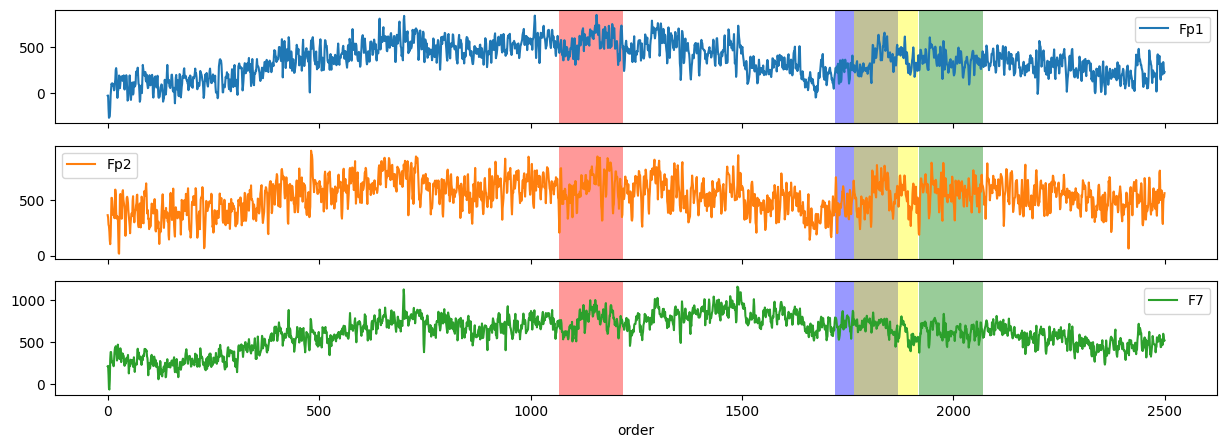

In [25]:
secondsToShow = 5
channelsToShow = 3
labelsToShow = 6

eeg_channels = train_set_signals.columns.drop('id')
sample_set = train_set_complete[train_set_complete["order"] < secondsToShow*500].drop("id", axis=1).set_index("order") #sample rate is 500hz 
colors=["red","blue","yellow","green", "purple", "black"]
axes = sample_set.plot(y=eeg_channels[:channelsToShow],subplots=True, figsize=(15,5))
    
for axis in axes:    
    colorindex = 0
    for label in labels[:labelsToShow]:
        highlight(sample_set[sample_set[label]==1].index, axis, colors[colorindex])        
        colorindex = colorindex + 1

plt.show()

Helper methods for loading data

Features are standartized by removing the mean and scaling to unit variance

Further preprocessing can be done in *prepare_signals* function

In [26]:
import math
from sklearn.preprocessing import StandardScaler

def load_train_data(subject, series):
    train_set_signals = pd.read_csv(f"data/train/subj{subject}_series{series}_data.csv")
    train_set_labels = pd.read_csv(f"data/train/subj{subject}_series{series}_events.csv")
    return train_set_signals, train_set_labels
    
def load_all_test_data():
    signals_dfs=[]
    for i in range(1,13):
        for j in range(9,11):            
            signals = pd.read_csv(f"data/test/subj{i}_series{j}_data.csv")
            signals_dfs.append(signals)
    return pd.concat(signals_dfs)       

def load_test_data(subject):
    signals_dfs=[]    
    for i in range(9,11):            
        signals = pd.read_csv(f"data/test/subj{subject}_series{i}_data.csv")
        signals_dfs.append(signals)
    return pd.concat(signals_dfs) 

def load_test_data_series(subject, series):
    return pd.read_csv(f"data/test/subj{subject}_series{series}_data.csv") 

def prepare_labels(data):    
    return data.drop("id", axis=1)
    
def prepare_signals(data):
    data = data.drop("id", axis=1)
    columns = data.columns      
    
    #Preprocessing    
    scaler = StandardScaler() 
    data =np.asarray(data.astype(float))
    data = scaler.fit_transform(data)
    data = pd.DataFrame(data, columns=columns) 
    
    return data
    
def load_train_data_prepared(subject, series):    
    signals, labels = load_train_data(subject,series)    
    return prepare_signals(signals), prepare_labels(labels)   

def split_data(data_to_split, percent):
    percenttotrainon = percent
    spliton = math.floor(float(len(data_to_split))*(percenttotrainon/float(100)))
    return data_to_split.iloc[:spliton], data_to_split[spliton:]   

def load_mass_data(fromsubj, tosubj): #we have 12 subjects
    signals_dfs=[]
    labels_dfs=[]
    for i in range(1,9): #we have 8 series availible for each subject
        for j in range(fromsubj, tosubj+1):
            signals, labels = load_train_data_prepared(subject=j, series=i)
            signals_dfs.append(signals)
            labels_dfs.append(labels)        

    signals_complete=pd.concat(signals_dfs)
    labels_complete=pd.concat(labels_dfs)
    return signals_complete, labels_complete 

def load_mass_data_subject(subject, fromseries, toseries): 
    signals_dfs=[]
    labels_dfs=[]
    for i in range(fromseries,toseries+1):        
        signals, labels = load_train_data_prepared(subject, series=i)
        signals_dfs.append(signals)
        labels_dfs.append(labels)        

    signals_complete=pd.concat(signals_dfs)
    labels_complete=pd.concat(labels_dfs)
    return signals_complete, labels_complete 

Helper for printing success rates for given predictions and expected values

In [27]:
def rd(x):
        return round(x)

def printSucc(predictions, expected, dataLabel):
    #success counters
    succ = 0
    onesTotal = 0
    onesSucc = 0
    
    #Compute successes in data
    for i in range(0, len(predictions)):    
        if(np.array_equal(list(map(rd, predictions[i])),expected[i])):
            succ+=1

        if 1 in expected[i]:
            onesTotal += 1           
            if(np.array_equal(list(map(rd, predictions[i])),expected[i])):
                onesSucc +=1           

    print(dataLabel, "success", "---","TOTAL =", "{:0.4f}".format(succ/len(predictions)), "|||","EVENT =","{:0.4f}".format(onesSucc/onesTotal) ,"(", onesSucc, "/",onesTotal, ")")    
    
    return succ/len(predictions), onesSucc/onesTotal

**RECURRENT NEURAL NETWORK**

RNN with LSTM, dropout and activation layers

* Adam optimizer
* Binary crossentropy loss 
* Sigmoid activation layer

Transform 2D dataset to 3D for LSTM layer - add floating window of *look_back* length

In [28]:
def create_sequences(dataset,labels, look_back=1):
    dataX = []
    dataY = labels[look_back:]
    for i in range(len(dataset)-look_back):
        dataX.append(dataset[i:(i+look_back), ])
    return np.array(dataX), np.array(dataY)


Tests given rnn model on predicting label or more labels from testing data.

Provides visualisations and success rates.





In [29]:
def evaluate_rnn(subject, model, config, LabelsRange, draw):
    #Last (8th) series is used as testing data
    test_signals, test_labels = load_train_data_prepared(subject=subject,series=8)
    
    #Creating sequences for lstm layer
    X_test_signals, X_test_labels = create_sequences(
        test_signals.values[::config.DOWNSAMPLING],
        test_labels.values[::config.DOWNSAMPLING],
        look_back=config.LOOK_BACK
    )
    #Selecting only desired labels
    X_test_labels = X_test_labels[:,LabelsRange[0]:LabelsRange[1]] 

    #Last few data points that do not fit batch size are omitted 
    croppedSize = math.floor(len(X_test_signals)/config.BATCH_SIZE)*config.BATCH_SIZE    

    #Prediction for testing data
    predictions = model.predict(X_test_signals[0:croppedSize], batch_size=config.BATCH_SIZE)
    expected = X_test_labels[0:croppedSize]
    
    #Selecting only desired labels   
    labelsPredicted = len(predictions[0])
    if(labelsPredicted == 1):
        predictions = predictions[:,0:1]
    else: #6 labels predicted    
        predictions = predictions[:,LabelsRange[0]:LabelsRange[1]] 
    
            
    #Success rate printing    
    totalPercent, onesPercent = printSucc(predictions,expected, dataLabel="Testing")
    
    #Vizualization
    if(draw):
        vizualize_predictions(
            test_signals.values[::config.DOWNSAMPLING][config.LOOK_BACK:croppedSize+config.LOOK_BACK:],
            predictions,
            expected,
            labelName = labelNames[LabelsRange[0]],  
            limit = 1000
        )
    
    return totalPercent, onesPercent    

Training of a single model for a single or more subjects.

Uses series 1-7 (leaves series 8 for testing)

In [30]:
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Dropout

def train_rnn(subjects, labelToTrain, trainSeparateLabels, config, modelGenerator, callbacks): 
    #Calculating output size of trained model
    LabelsRange = [labelToTrain,labelToTrain+1]
    if(not trainSeparateLabels):
        LabelsRange = [0,6]
    OutputSize = LabelsRange[1] - LabelsRange[0]     
    #Model creation
    model = modelGenerator(config, output_size = OutputSize) 
    
    #Training
    for i in range(config.ITERATIONS):
        #For specified subjects
        for subject in subjects:
            #For series 1-7 
            for j in range(1,8):
                signals, labels = load_train_data_prepared(subject = subject,series = j) 
                #Create sequences
                X_train_signals, X_train_labels = create_sequences(
                    signals.iloc[::config.DOWNSAMPLING].values,
                    labels.iloc[::config.DOWNSAMPLING].values,
                    look_back=config.LOOK_BACK       
                )        

                X_train_labels = X_train_labels[:,LabelsRange[0]:LabelsRange[1]]
                croppedSize = math.floor(len(X_train_signals)/config.BATCH_SIZE)*config.BATCH_SIZE        
                #Train model on relevant label (calling fit repeatedly in keras doesnt reset the model)
                model.fit(
                    X_train_signals[0:croppedSize],
                    X_train_labels[0:croppedSize],
                    epochs=config.EPOCHS,
                    batch_size=config.BATCH_SIZE,
                    shuffle=config.SHUFFLE,
                    verbose=config.VERBOSE,
                    callbacks=callbacks
                )            
                if(config.STATEFUL):
                    model.reset_states()
    
    
    print("FITTING DONE")
    return model, LabelsRange

Training of model for given subjects and evaluating it.

Evaluating each label success rate separarely and averaging them. Random behaviour has 50% success rate.

For given subject, we use first 7 series as training data and 8'th series as test data. 

In [31]:
def rnn_validation(subjects, modelGenerator, trainSeparateLabels, callbacks, draw=False, subjectToEvaluateOn = 1, labels=[0,1,2,3,4,5]):
    config = Config()
    totalPercentages = []
    onesPercentages = []   
    
    model = None
    labelsRange = None
    
    #One model for training on all labels combined
    if(not trainSeparateLabels):
        model, labelsRange = train_rnn(
            subjects=subjects,
            labelToTrain = -1, #doesnt matter
            trainSeparateLabels = False,
            config = config,
            modelGenerator = modelGenerator,
            callbacks=callbacks
        )   
    
    for i in labels:
        #Separate models for training all labels separately
        model, labelsRange = train_rnn(  
            subjects = subjects,
            labelToTrain=i,
            trainSeparateLabels=True,
            config=config,
            modelGenerator = modelGenerator,
            callbacks=callbacks
            )
        print(labelNames[i],"label model evaluation")
        
        total, ones = evaluate_rnn(subjectToEvaluateOn, model, config, LabelsRange=[i,i+1], draw = draw)
        totalPercentages.append(total)
        onesPercentages.append(ones)        

    print("SUMMARY")
    print("TOTAL :", sum(totalPercentages)/len(totalPercentages))
    print("EVENTS :", sum(onesPercentages)/len(onesPercentages))

RNN configuration

In [32]:
def create_stacked_rnn_model(config, output_size):      
    model = Sequential()
    model.add(LSTM(50,batch_input_shape=(config.BATCH_SIZE,config.LOOK_BACK,32), return_sequences=True, stateful=config.STATEFUL, dropout=0.5, activation="softsign")) 
    model.add(LSTM(50, return_sequences=False, stateful=config.STATEFUL, dropout=0.5, activation="softsign"))     
    model.add(Dense(output_size, activation="sigmoid"))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

class Config(object):
    #data are downsampled, each 15th data point is taken
    DOWNSAMPLING = 15
    LOOK_BACK = 35
    BATCH_SIZE = 512

    #Iterations on stateful model, epochs on non-stateful
    EPOCHS = 30
    ITERATIONS = 1
    STATEFUL = False
    SHUFFLE = not STATEFUL
    VERBOSE = 0    

In [33]:
from keras.callbacks import EarlyStopping

callbacks=[EarlyStopping(monitor="accuracy", verbose=0, patience=10, restore_best_weights=True)]

Basic model, training all labels at once for single subject

Stacked model, training all labels separately for single subject

FITTING DONE
HandStart label model evaluation
16/16 [==============================] - 1s 40ms/step
Testing success --- TOTAL = 0.9231 ||| EVENT = 0.1382 ( 47 / 340 )


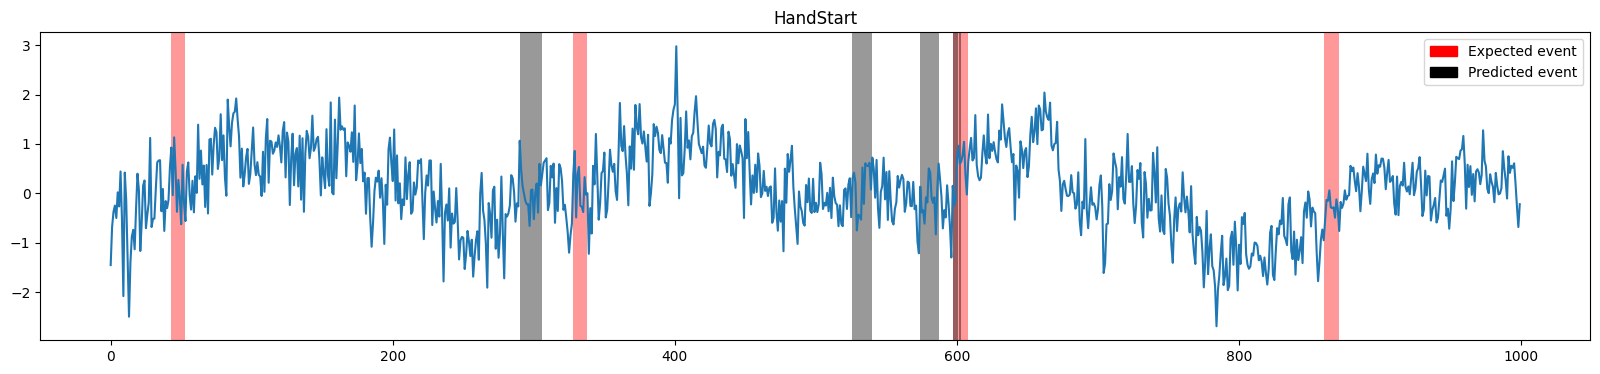

SUMMARY
TOTAL : 0.923095703125
EVENTS : 0.13823529411764707


In [34]:
rnn_validation(subjects=[1],
               modelGenerator = create_stacked_rnn_model,
               trainSeparateLabels=True,
               draw=True,
               subjectToEvaluateOn=10,
               callbacks=callbacks,
               labels=[0]
              )